# LinDHA Mk. 3 (Feature Engineering)

In this notebook, we will perform feature engineering. The primary goal is to address to issues we have observed with the previous model:
1) Underfitting at the tail-ends (the residual plots tend to slightly curl upward at the tails).
2) Heteroskedasticity (the residuals tend to fan-out as the values get large).

To address the 1st problem, we use ordinal encodings, interaction terms, and square-root terms. To address the 2nd problem, we will perform a log-transform on the target variable and regress the log Sale Price of houses, then use exponentiation to invert the transform the output values back into actual Sale Prices.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score


pd.options.display.max_columns = 100
pd.options.display.max_rows = 2000


import PaulBettany as jarvis

In [44]:
# read in data and drop outlier
train = pd.read_csv('../data/train.csv', index_col = 'Id')
total = pd.read_csv('../data/ames-cleaned.csv', index_col = 'Id')

train.drop(index=2181, inplace=True)
total.drop(index=2181, inplace=True)


<br>

## Ordinal Encodings

To encode our ordinals, we will have to specify and ordered array representing the ordering of the classes in each of the ordinal categories.

In [45]:
# list out the categories we want to encode as ordinals
ord_feat = ['Lot Shape', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 
            'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Pool QC', 
            'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
           'Fence']

# Order categories for each ordinal from least to greatest
# Left-most class receives grade 0, then 1, then 2, and so on
lotshape = ['No Feature', 'IR3', 'IR2', 'IR1', 'Reg']
exterqual = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
extercond = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmtqual = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmtcond = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmtexposure = ['No Feature', 'No', 'Mn', 'Av', 'Gd']
bsmtfintype1 = ['No Feature', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmtfintype2 = ['No Feature', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
heatingqc = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
poolqc = ['No Feature', 'Fa', 'TA', 'Gd', 'Ex']
kitchenqual = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
functional = ['No Feature', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
fireplacequ = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
garagequal = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
garagecond = ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
fence = ['No Feature', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']


gradesdict = { 'Lot Shape' : lotshape, 'Exter Qual' : exterqual, 'Exter Cond' : extercond, 'Bsmt Qual': bsmtqual, 'Bsmt Cond' : bsmtcond,
           'Bsmt Exposure' : bsmtexposure, 'BsmtFin Type 1' : bsmtfintype1, 'BsmtFin Type 2' : bsmtfintype2, 'Heating QC' : heatingqc,
           'Pool QC' : poolqc, 'Kitchen Qual' : kitchenqual, 'Functional' : functional, 'Fireplace Qu' : fireplacequ, 'Garage Qual' : garagequal,
           'Garage Cond' : garagecond, 'Fence' : fence }


In [46]:
# ask jarvis to encode the ordinals according to the schematic above
total = jarvis.encode_ordinals(total, ord_feat, gradesdict, start=0)

<br> 

## Interaction Terms

The purpose of encoding the ordinals as integers is to create terms with other variables. The idea is to use the quality variables (ordinals) as a way to magnify or penalize the size/aggregate variables (numericals).

For example: a poor quality house should be worth less per square foot, than a high quality house. Thus there should be some kind of proportional/multiplicative effect between quality and square footage.

In [47]:
# set up lists of interaction terms
columns1 = ['Lot Area']*4 + ['Gr Liv Area']*3 + ['Total Bsmt SF']*2 + ['BsmtFin SF 1', 'BsmtFin SF 2'] + ['Garage Area']*2 + ['Fireplaces']
columns2 = ['Lot Shape_ord', 'Exter Qual_ord', 'Exter Cond_ord', 'Functional_ord', 'Functional_ord', 'Heating QC_ord',
            'Kitchen Qual_ord', 'Bsmt Qual_ord', 'Bsmt Cond_ord', 'BsmtFin Type 1_ord', 'BsmtFin Type 2_ord',
            'Garage Qual_ord', 'Garage Cond_ord', 'Fireplace Qu_ord']

len(columns1), len(columns2)

(14, 14)

In [48]:
# interaction column names
interactions = [col1+' * '+col2 for col1, col2 in zip(columns1, columns2)]

interactions

['Lot Area * Lot Shape_ord',
 'Lot Area * Exter Qual_ord',
 'Lot Area * Exter Cond_ord',
 'Lot Area * Functional_ord',
 'Gr Liv Area * Functional_ord',
 'Gr Liv Area * Heating QC_ord',
 'Gr Liv Area * Kitchen Qual_ord',
 'Total Bsmt SF * Bsmt Qual_ord',
 'Total Bsmt SF * Bsmt Cond_ord',
 'BsmtFin SF 1 * BsmtFin Type 1_ord',
 'BsmtFin SF 2 * BsmtFin Type 2_ord',
 'Garage Area * Garage Qual_ord',
 'Garage Area * Garage Cond_ord',
 'Fireplaces * Fireplace Qu_ord']

In [49]:
# ask jarvis to create interaction terms
total = jarvis.create_interaction(total, [columns1, columns2])

In [50]:
# check to see if everything worked
total.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       ...
       'Gr Liv Area * Functional_ord', 'Gr Liv Area * Heating QC_ord',
       'Gr Liv Area * Kitchen Qual_ord', 'Total Bsmt SF * Bsmt Qual_ord',
       'Total Bsmt SF * Bsmt Cond_ord', 'BsmtFin SF 1 * BsmtFin Type 1_ord',
       'BsmtFin SF 2 * BsmtFin Type 2_ord', 'Garage Area * Garage Qual_ord',
       'Garage Area * Garage Cond_ord', 'Fireplaces * Fireplace Qu_ord'],
      dtype='object', length=106)

In [51]:
total.shape

(2928, 106)

In [52]:
# list of features to use for model
features = ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
             'BsmtFin SF 1', 'Total Bsmt SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
             'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Fireplaces', 'Garage Area', 
             'Wood Deck SF', 'Open Porch SF', '1st Flr SF', 'TotRms AbvGrd', 'Bsmt Unf SF',
             'Screen Porch', 'Overall Cond', 'MS Zoning', 'Neighborhood', 'House Style', 
             'Roof Matl', 'Exterior 1st', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
             'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Central Air', 'Kitchen Qual',
             'Pool QC', 'MS SubClass', 'Lot Shape', 'Foundation', 'Land Contour'] + interactions

columns = [col for col in total.columns if col in features + ['SalePrice'] ]

<br> 

## The Mk 3

We build a new model using the features and interactions constructed above.

In [53]:
# create a new project
lindhamk3_1 = jarvis.Project( 
                    total[columns].iloc[ : len(train.index) ], 
                    total[columns].iloc[ len(train.index) : ],
                    target = 'SalePrice',
                    name = 'LinDHA MK 3.1'
                )

lindhamk3_1.num_to_cat(columns=['MS SubClass'])

In [54]:
# preparations for training
lindhamk3_1.model = LinearRegression()

lindhamk3_1.seed = 42 

lindhamk3_1.prepare_data()

lindhamk3_1.cross_val()

C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.7249249461359896

In [55]:
# prototype model
lindhamk3_1.prototype()

 
R2 :0.9454346406067359
MSE: 341367484.99413586
RMSE: 18476.132847382753
MAE: 12550.014709932635
 


In [56]:
lindhamk3_1.grade()

          Train                    Test       
R2:   0.9454346406067359,   0.9390978401349362
MSE:  341367484.99413586,  388745505.04046655
RMSE: 18476.132847382753,   19716.63016441873
MAE:  12550.014709932635,   13909.056663904767


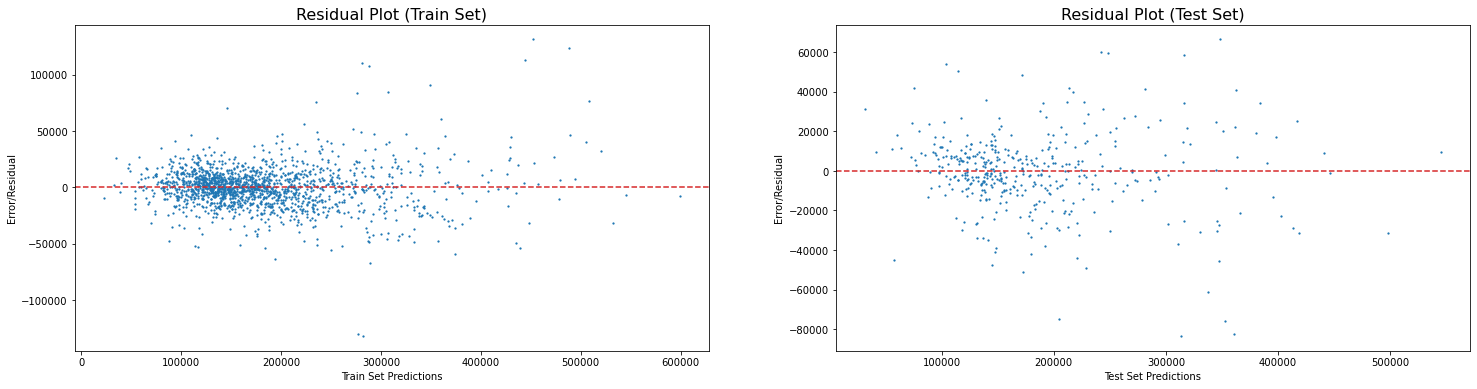

In [57]:
lindhamk3_1.plot_residuals(slice='both')

<br> 

The Mk 3.1 performs about as well as the finalized Mk 2 model, so it doesn't seem like our additional features had too much of a dramatmic effect.

<br> 

## Square Root Terms

As a last ditch effort before automating the feature search with LASSO, we'll add in some square-root features as well and combine the ```1st Flr SF``` and ```2nd Flr SF``` variables as one.

In [58]:
# combine 1st and 2nd floor area
total['1st Flr SF + 2nd Flr SF'] = total['1st Flr SF'] + total['2nd Flr SF']

# list out square root features
sqrtfeatures = ['Lot Area', 'Gr Liv Area', '1st Flr SF', '2nd Flr SF', 'Mas Vnr Area', 'Total Bsmt SF', 'Garage Area']

# ask jarvis to make features for us
total = jarvis.sqrt_features(total, sqrtfeatures)

# list of columns we'll need for the model
columns = [col for col in total.columns if col in lindhamk3_1.features + ['SalePrice'] ] + ['1st Flr SF + 2nd Flr SF'] + [col+'_sqrt' for col in sqrtfeatures]

In [59]:
# check to see if columns created properly
total.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       ...
       'Garage Area * Garage Cond_ord', 'Fireplaces * Fireplace Qu_ord',
       '1st Flr SF + 2nd Flr SF', 'Lot Area_sqrt', 'Gr Liv Area_sqrt',
       '1st Flr SF_sqrt', '2nd Flr SF_sqrt', 'Mas Vnr Area_sqrt',
       'Total Bsmt SF_sqrt', 'Garage Area_sqrt'],
      dtype='object', length=114)

In [60]:
# create a new project
lindhamk3_2 = jarvis.Project( 
                    total[columns].iloc[ : len(train.index) ], 
                    total[columns].iloc[ len(train.index) : ],
                    target = 'SalePrice',
                    name = 'LinDHA MK 3.2'
                )

lindhamk3_2.num_to_cat(columns=['MS SubClass'])

In [61]:
print(lindhamk3_2.features)

['MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape', 'Land Contour', 'Neighborhood', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', 'Central Air', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Screen Porch', 'Pool QC', 'Lot Area * Lot Shape_ord', 'Lot Area * Exter Qual_ord', 'Lot Area * Exter Cond_ord', 'Lot Area * Functional_ord', 'Gr Liv Area * Functional_ord', 'Gr Liv Area * Heating QC_ord', 'Gr Liv Area * Kitchen Qual_ord', 'Total Bsmt SF * Bsmt Qual_ord', 'Total Bsmt SF * Bsmt Cond_ord', 'BsmtFin SF 1 * BsmtFin Type 1_ord', 'BsmtFin SF 2 * BsmtFin Type 2_ord', 'Garage Area * Garage Qual_ord', 'Garage Area * Ga

In [62]:
# preparation for training
lindhamk3_2.model = LinearRegression()

lindhamk3_2.seed = 42 

lindhamk3_2.prepare_data()

lindhamk3_2.cross_val()



C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.6973196494531946

In [63]:
# build prototype
lindhamk3_2.prototype()

 
R2 :0.9462189179019425
MSE: 336460951.42082775
RMSE: 18342.871951273817
MAE: 12486.092876538325
 


In [64]:
lindhamk3_2.grade()

          Train                    Test       
R2:   0.9462189179019425,   0.9408849890511647
MSE:  336460951.42082775,  377337927.5496018
RMSE: 18342.871951273817,   19425.187966905283
MAE:  12486.092876538325,   13616.971054503707


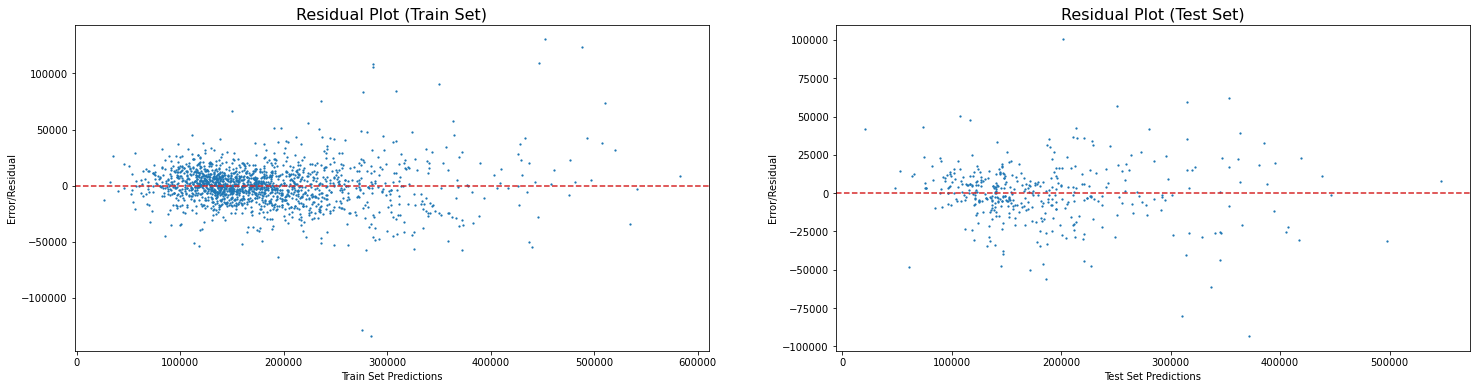

In [65]:
lindhamk3_2.plot_residuals(slice='both')

<br> 

## Log Scaling

One final feature manipulation we will try: log scaling the target variable. This usually helps with heteroskedascity and may help control the variance of the errors, which is critical for minimizing risk on pricing estimates (such as housing appraisal).

In [66]:
lindhamk3_3 = jarvis.Project( 
                    total[columns].iloc[ : len(train.index) ], 
                    total[columns].iloc[ len(train.index) : ],
                    target = 'SalePrice',
                    name = 'LinDHA MK 3.3'
                )

lindhamk3_3.num_to_cat(columns=['MS SubClass'])

In [67]:
# log transform on target variable.
lindhamk3_3.y = np.log(lindhamk3_3.y)

In [68]:
# preparation
lindhamk3_3.model = LinearRegression()

lindhamk3_3.seed = 42 

lindhamk3_3.prepare_data()

lindhamk3_3.cross_val()


C:\Users\herma\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.8596481912050111

In [69]:
# prototyping
lindhamk3_3.prototype()

 
R2 :0.9428575469915432
MSE: 0.009636731611095246
RMSE: 0.09816685597030826
MAE: 0.06846999979313678
 


In [70]:
# inverting the log transform on the output vectors
lindhamk3_3.y_train = np.exp(lindhamk3_3.y_train)
lindhamk3_3.y_test = np.exp(lindhamk3_3.y_test)

lindhamk3_3.y_trainpred = np.exp(lindhamk3_3.y_trainpred)
lindhamk3_3.y_testpred = np.exp(lindhamk3_3.y_testpred)

lindhamk3_3.train_errors = lindhamk3_3.y_train - lindhamk3_3.y_trainpred
lindhamk3_3.test_errors = lindhamk3_3.y_test - lindhamk3_3.y_testpred

In [71]:
lindhamk3_3.grade()

          Train                    Test       
R2:   0.951703261316216,   0.9369241504605728
MSE:  302150235.99638546,  402620416.73709446
RMSE: 17382.469214596225,   20065.403478053824
MAE:  11720.582996916111,   13779.676302686874


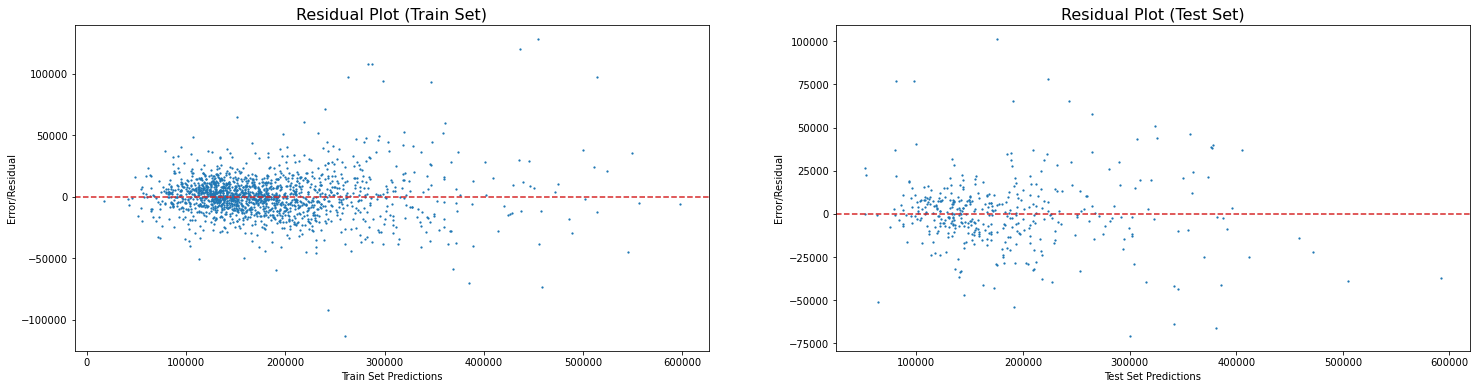

In [72]:
lindhamk3_3.plot_residuals(slice='both')

In [73]:
lindhamk3_3.build_model()

In [74]:
len(lindhamk3_3.features), len(lindhamk3_3.numericals), len(lindhamk3_3.categoricals)

(62, 44, 18)

In [75]:
# prepare model for kaggle submissions
lindhamk3_3.submissions['SalePrice'] = np.exp(lindhamk3_3.model.predict(lindhamk3_3.X_unknown))

C:\Users\herma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\herma\AppData\Local\Temp\ipykernel_18600\362216760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindhamk3_3.submissions['SalePrice'] = np.exp(lindhamk3_3.model.predict(lindhamk3_3.X_unknown))


In [76]:
lindhamk3_3.submissions

,SalePrice
Id,
2658,108161.313255
2718,151953.295768
2414,209199.859304
1989,100127.005115
625,171179.203101
333,88545.852825
1327,115683.837455
858,154851.321260
95,181292.041990


In [77]:
# write kaggle submissions to csv
lindhamk3_3.submissions.to_csv('../data/lindhamk3-submission.csv')

In [78]:
# save model
lindhamk3_3.save(csv=False, pkl=True, pkl_path='../saved-files/lindhamk3-final.pkl')

In [79]:
# save our engineered features, minus the interaction terms
# since the interaction terms can be recovered using PolynomialFeatures()
total.drop(columns=interactions).to_csv('../data/ames-engineered.csv')